In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# GOAL: Dada la sinopsis de una película (texto), predecir todas los géneros a los que pertenece.
#
# https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags
# https://medium.com/towards-artificial-intelligence/keras-for-multi-label-text-classification-86d194311d0e

In [ ]:
# Natural language toolkit, nos ayudara con preprocessing de los datos
import nltk
nltk.download('stopwords')

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

# Imprime el set
print(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'him', 'here', 'you', 'few', 'ain', 'some', "hadn't", 'should', "she's", 'above', 'nor', 'no', 'aren', 'off', 'does', 'where', "shouldn't", 'these', 'then', 'how', "didn't", 'yours', 'don', 'who', 'about', 'have', 'such', 'they', 'needn', 'did', 'he', 'but', 'than', 'ma', 'most', 'was', 'for', 'having', 's', 'as', 'during', 'me', 't', "hasn't", 'all', 'haven', "wasn't", 'once', 'of', 'yourselves', "couldn't", 'again', 'had', 'only', 'itself', 'just', "needn't", 'she', 'the', 'doesn', 'an', 'shouldn', "don't", 'his', 'further', 'by', 'm', 'won', "mightn't", 'when', "doesn't", 'this', 'herself', 'my', 'from', 'down', 'ours', 'hers', 'a', 'very', 've', 'shan', 'will', 'it', 'd', 'against', "weren't", 'wasn', 'those', "shan't", 'or', 'your', 'her', 'we', 'be', 'is', 'didn', "wouldn't", "that'll", 'yourself', 'into', 'below', 'weren', "you've", 'until', "should've", 'other', "have

# Part 1: Load and split data

In [ ]:
# Requiered to select a file to be imported into colab
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# Load file from colab (G drive)
# Esto lo puedes modificar si lo estás corriendo localemente en vez de hacerlo en colab
df = pd.read_csv('mpst_full_data.csv', delimiter=',')
df.dropna(inplace=True)
df

imdb_id  ... synopsis_source
0      tt0057603  ...            imdb
1      tt1733125  ...            imdb
2      tt0033045  ...            imdb
3      tt0113862  ...            imdb
4      tt0086250  ...            imdb
...          ...  ...             ...
14823  tt0219952  ...       wikipedia
14824  tt1371159  ...       wikipedia
14825  tt0063443  ...       wikipedia
14826  tt0039464  ...       wikipedia
14827  tt0235166  ...       wikipedia

[14828 rows x 6 columns]

In [ ]:
# Imprime un ejemplo de las sinopsis
df['plot_synopsis'][4]

'In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the "American Dream" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony\'s left arm of a black heart with a pitchfork through it, which identifies him as a hitman, and detain him in a camp called \'Freedomtown\' with other Cubans, including Tony\'s best friend and former Cuban Army buddy Manolo "Manny Ray" Ribiera (Steven Bauer), under the local I-95 expressway while the government evaluates their visa petitions.After 30 days of governmental dithering and camp rumors, Manny receives an offer from the Cuban Mafia which he quickly relays to Tony. If they kill Emilio Rebenga (Roberto Contreras) a former aide to Fidel Castro who is now detained in Freedomtown, they will receive green cards. Tony agrees, and kills Rebenga during a riot at Freedomtown. The murder of Rebenga was requested by Frank Lópe

In [ ]:
# Checking for NaN values.
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 imdb_id            0
title              0
plot_synopsis      0
tags               0
split              0
synopsis_source    0
dtype: int64


In [ ]:
# Split data: train, val, and test
df_x_train = df.loc[df['split'] == 'train', 'plot_synopsis']
df_x_val   = df.loc[df['split'] == 'val', 'plot_synopsis']
df_x_test  = df.loc[df['split'] == 'test', 'plot_synopsis']

df_y_train = df.loc[df['split'] == 'train', 'tags']
df_y_val   = df.loc[df['split'] == 'val', 'tags']
df_y_test  = df.loc[df['split'] == 'test', 'tags']

print(df_x_train.shape)
print(df_x_val.shape)
print(df_x_test.shape)
print(df_y_train.shape)
print(df_y_val.shape)
print(df_y_test.shape)

(9489,)
(2373,)
(2966,)
(9489,)
(2373,)
(2966,)


In [ ]:
print(df_y_train[0])
print(df_x_train[0])

cult, horror, gothic, murder, atmospheric
Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary i

# Part 2: Format data accordingly

In [ ]:
# Aux funcción para substituir abreciacioes
import re
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [ ]:
# Set adicional de stopwords, removeremos palabras tanto de este set como del que
# viene definido en el nltk
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Función auxiliar para remover stopwords y otras normalizaciones de texto
# (Aqui puedes incluir el lematizador o stemming si gustas explorarlos)
def remove_stopwords(dataframe):
  SYNS = []
  for sentance in dataframe:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in STOPWORDS)
    SYNS.append(sentance.strip())
  return SYNS

In [ ]:
# Remueve stopwords
synops_train = remove_stopwords(df_x_train)
synops_val   = remove_stopwords(df_x_val)
synops_test  = remove_stopwords(df_x_test)

In [ ]:
synops_train[:10]

['note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset series strange phone calls caller soon identified frank ex pimp recently escaped prison rosy terrified testimony landed man jail looking solace rosy phones lesbian lover mary lynda alfonsi two women estranged time rosy certain one help mary agrees come night seconds later frank calls promising matter calls protection revenge unknown rosy mary caller impersonating frank marry arrives rosy apartment soon best calm rosy nerves gives panic struck woman tranquillizer puts bed later night rosy sleeps mary gets bed pens note confession one making strange phone calls learned franks escape prison knowing rosy would call help explains felt way coming back life breakup busy writing fails notice intruder apartmen

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Entrena un Tokenizer
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las XXXX palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(synops_train)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 98800
[('tells', 1), ('one', 2), ('back', 3), ('man', 4), ('two', 5), ('get', 6), ('house', 7), ('time', 8), ('go', 9), ('goes', 10)]


In [ ]:
#sorted(tokenizer.word_counts.values())[-30:]
#Tokenizer?

In [ ]:
# REVISA distribución: calcula 
y_hist, x_hist = np.histogram(sorted(tokenizer.word_counts.values()), 100)
print(x_hist)
print(y_hist)

[1.000000e+00 2.048300e+02 4.086600e+02 6.124900e+02 8.163200e+02
 1.020150e+03 1.223980e+03 1.427810e+03 1.631640e+03 1.835470e+03
 2.039300e+03 2.243130e+03 2.446960e+03 2.650790e+03 2.854620e+03
 3.058450e+03 3.262280e+03 3.466110e+03 3.669940e+03 3.873770e+03
 4.077600e+03 4.281430e+03 4.485260e+03 4.689090e+03 4.892920e+03
 5.096750e+03 5.300580e+03 5.504410e+03 5.708240e+03 5.912070e+03
 6.115900e+03 6.319730e+03 6.523560e+03 6.727390e+03 6.931220e+03
 7.135050e+03 7.338880e+03 7.542710e+03 7.746540e+03 7.950370e+03
 8.154200e+03 8.358030e+03 8.561860e+03 8.765690e+03 8.969520e+03
 9.173350e+03 9.377180e+03 9.581010e+03 9.784840e+03 9.988670e+03
 1.019250e+04 1.039633e+04 1.060016e+04 1.080399e+04 1.100782e+04
 1.121165e+04 1.141548e+04 1.161931e+04 1.182314e+04 1.202697e+04
 1.223080e+04 1.243463e+04 1.263846e+04 1.284229e+04 1.304612e+04
 1.324995e+04 1.345378e+04 1.365761e+04 1.386144e+04 1.406527e+04
 1.426910e+04 1.447293e+04 1.467676e+04 1.488059e+04 1.508442e+04
 1.528825e

In [ ]:
# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(synops_train)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Shortest article with", np.array(lengths).min(), "words.")
print("Longest article with", np.array(lengths).max(), "words.")
print(f"Average length: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

for seq in train_sequences[:10]:
  print(seq)

Shortest article with 9 words.
Longest article with 2951 words.
Average length: 229.58 +- 231.08 words.


[678, 193, 908, 64, 444, 64, 822, 250, 153, 92, 73, 796, 143, 473, 297, 31, 523, 598, 164, 96, 79, 156, 743, 296, 4, 820, 184, 231, 5, 263, 8, 2, 39, 231, 180, 75, 27, 15, 156, 96, 96, 540, 231, 156, 437, 66, 143, 79, 335, 77, 53, 381, 251, 15, 27, 231, 31, 251, 678, 2, 248, 598, 164, 96, 85, 296, 579, 44, 153, 39, 137, 40, 422, 3, 34, 143, 8, 156, 229, 108, 231, 45, 2, 151, 46, 723, 53, 838, 86, 40, 251, 35, 339, 27, 498, 231, 498, 988, 156, 943, 744, 498, 265, 5, 279, 58, 165, 669, 892, 17, 498, 386, 21, 15, 27, 416, 186, 590, 365, 127, 2, 871, 2, 732, 137, 498, 12, 233, 556, 281, 255, 23, 58, 908, 305, 36, 50, 58, 63, 726, 119, 210, 12, 95, 970, 398, 341, 137, 552, 216, 273, 388, 88, 36, 419, 732, 19, 738, 12, 216, 42, 97, 226, 59, 90, 73, 5, 639, 738, 49, 36, 47, 86, 636, 15, 27, 445, 216, 860, 50, 617, 427, 180, 214, 196, 213, 27, 214, 994, 30, 83, 63, 147, 142, 202, 72, 59, 4

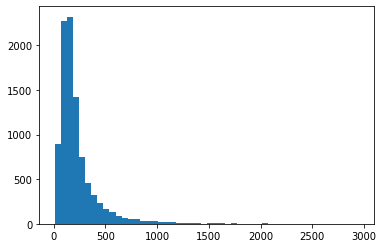

In [ ]:
plt.hist(lengths, 50)
plt.show()

In [ ]:
# Hace todos los artículos del mismo tamaño usando padding y truncando
# Usaré maxlen = 1000
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(train_sequences, maxlen=128, padding='pre', truncating='post')
lengths = []
for seq in x_train:
  lengths.append(len(seq))

print("Shortest article with", np.array(lengths).min(), "words.")
print("Longest article with", np.array(lengths).max(), "words.")
print("Average length:", np.array(lengths).mean(), "words.")
print('\n')

print((train_sequences[0]))
print((x_train[0]))

print((train_sequences[1]))
print((x_train[1]))

print((train_sequences[10]))
print((x_train[10]))

print('\n Max word index:', x_train.max())

Shortest article with 128 words.
Longest article with 128 words.
Average length: 128.0 words.


[678, 193, 908, 64, 444, 64, 822, 250, 153, 92, 73, 796, 143, 473, 297, 31, 523, 598, 164, 96, 79, 156, 743, 296, 4, 820, 184, 231, 5, 263, 8, 2, 39, 231, 180, 75, 27, 15, 156, 96, 96, 540, 231, 156, 437, 66, 143, 79, 335, 77, 53, 381, 251, 15, 27, 231, 31, 251, 678, 2, 248, 598, 164, 96, 85, 296, 579, 44, 153, 39, 137, 40, 422, 3, 34, 143, 8, 156, 229, 108, 231, 45, 2, 151, 46, 723, 53, 838, 86, 40, 251, 35, 339, 27, 498, 231, 498, 988, 156, 943, 744, 498, 265, 5, 279, 58, 165, 669, 892, 17, 498, 386, 21, 15, 27, 416, 186, 590, 365, 127, 2, 871, 2, 732, 137, 498, 12, 233, 556, 281, 255, 23, 58, 908, 305, 36, 50, 58, 63, 726, 119, 210, 12, 95, 970, 398, 341, 137, 552, 216, 273, 388, 88, 36, 419, 732, 19, 738, 12, 216, 42, 97, 226, 59, 90, 73, 5, 639, 738, 49, 36, 47, 86, 636, 15, 27, 445, 216, 860, 50, 617, 427, 180, 214, 196, 213, 27, 214, 994, 30, 83, 63, 147, 142, 202, 72, 59, 4, 93, 642,

In [ ]:
# También para datos de val y test
val_sequences = tokenizer.texts_to_sequences(synops_val)
x_val = pad_sequences(val_sequences, maxlen=128, padding='pre', truncating='post')

test_sequences = tokenizer.texts_to_sequences(synops_test)
x_test = pad_sequences(test_sequences, maxlen=128, padding='pre', truncating='post')

In [ ]:
# Ahora cambiemos las etiquetas
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['tags']) # Entrena un Tokenizer para etiquetas

print("Number of words in the dictionary", len(label_tokenizer.word_index))
print(list(label_tokenizer.word_index.items()))

Number of words in the dictionary 82
[('murder', 1), ('violence', 2), ('flashback', 3), ('romantic', 4), ('cult', 5), ('revenge', 6), ('comedy', 7), ('psychedelic', 8), ('suspenseful', 9), ('good', 10), ('versus', 11), ('evil', 12), ('humor', 13), ('satire', 14), ('entertaining', 15), ('neo', 16), ('noir', 17), ('action', 18), ('sadist', 19), ('insanity', 20), ('tragedy', 21), ('fantasy', 22), ('paranormal', 23), ('boring', 24), ('mystery', 25), ('horror', 26), ('melodrama', 27), ('cruelty', 28), ('gothic', 29), ('historical', 30), ('dramatic', 31), ('dark', 32), ('atmospheric', 33), ('storytelling', 34), ('sci', 35), ('fi', 36), ('alternate', 37), ('psychological', 38), ('absurd', 39), ('realism', 40), ('prank', 41), ('sentimental', 42), ('philosophical', 43), ('avant', 44), ('garde', 45), ('bleak', 46), ('depressing', 47), ('plot', 48), ('twist', 49), ('reality', 50), ('cute', 51), ('stupid', 52), ('fiction', 53), ('intrigue', 54), ('pornographic', 55), ('home', 56), ('movie', 57), (

In [ ]:
label_tokenizer.word_counts

OrderedDict([('cult', 2647),
             ('horror', 486),
             ('gothic', 441),
             ('murder', 5782),
             ('atmospheric', 396),
             ('violence', 4426),
             ('romantic', 2906),
             ('inspiring', 118),
             ('stupid', 190),
             ('feel', 76),
             ('good', 951),
             ('cruelty', 442),
             ('dramatic', 412),
             ('action', 664),
             ('revenge', 2468),
             ('sadist', 652),
             ('queer', 98),
             ('flashback', 2937),
             ('mystery', 519),
             ('suspenseful', 1086),
             ('neo', 745),
             ('noir', 745),
             ('prank', 255),
             ('psychedelic', 1897),
             ('tragedy', 597),
             ('autobiographical', 44),
             ('home', 153),
             ('movie', 153),
             ('versus', 875),
             ('evil', 875),
             ('depressing', 205),
             ('realism', 258),
       

In [ ]:
# Usa el Tokenizer y convierte las etiquetas a formato de enteros
y_train_int = np.array(label_tokenizer.texts_to_sequences(df_y_train))
y_val_int   = np.array(label_tokenizer.texts_to_sequences(df_y_val))
y_test_int  = np.array(label_tokenizer.texts_to_sequences(df_y_test))

print("y train:")
print(y_train_int[0])
print(y_train_int[1])
print(y_train_int[2])
print(y_train_int.shape)

print("y val:")
print(y_val_int[0])
print(y_val_int[1])
print(y_val_int[2])
print(y_val_int.shape)

print("y test:")
print(y_test_int[0])
print(y_test_int[1])
print(y_test_int[2])
print(y_test_int.shape)

y train:
[5, 26, 29, 1, 33]
[2]
[63, 4, 52, 74, 10]
(9489,)
y val:
[28, 1, 31, 5, 2, 33, 18, 4, 6, 19]
[4, 70, 3]
[3]
(2373,)
y test:
[4]
[10, 11, 12]
[23, 26, 58]
(2966,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

In [ ]:
# AUX function to put a list of integer into binary vector form
def int2binary(LABELS, num_classes):
  y = np.zeros((len(LABELS), num_classes))

  for ind_lab, labels in enumerate(LABELS):
    for label in labels:
      y[ind_lab, label-1] = 1
      
  return y

In [ ]:
# Convert labels into binary vector form
# (We know there are 82 different classes)
y_train = int2binary(y_train_int, 82)
y_val = int2binary(y_val_int, 82)
y_test = int2binary(y_test_int, 82)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9489, 82)
(2373, 82)
(2966, 82)


In [ ]:
y_train.sum(axis=0)

array([3697., 2813., 1849., 1850., 1680., 1556., 1242., 1184.,  661.,
        593.,  548.,  548.,  527.,  532.,  450.,  464.,  464.,  423.,
        392.,  413.,  370.,  351.,  330.,  330.,  322.,  304.,  298.,
        282.,  285.,  266.,  254.,  257.,  264.,  233.,  197.,  197.,
        179.,  176.,  169.,  174.,  169.,  156.,  154.,  158.,  158.,
        139.,  125.,  123.,  123.,  129.,  116.,  111.,  127.,  106.,
        104.,   97.,   97.,   99.,   93.,   82.,   80.,   80.,   68.,
         71.,   71.,   63.,   71.,   77.,   64.,   64.,   59.,   52.,
         55.,   48.,   56.,   49.,   44.,   28.,   35.,   28.,   27.,
         25.])

# Part 3: Create LSTM

In [ ]:
print(x_train.shape)
print(y_train.shape)

(9489, 128)
(9489, 82)


In [ ]:
# Class weights
class_weights = 1 / y_train.sum(axis=0)
class_weights = class_weights / class_weights.sum()

print(y_train.sum(axis=0))
print(class_weights)

[3697. 2813. 1849. 1850. 1680. 1556. 1242. 1184.  661.  593.  548.  548.
  527.  532.  450.  464.  464.  423.  392.  413.  370.  351.  330.  330.
  322.  304.  298.  282.  285.  266.  254.  257.  264.  233.  197.  197.
  179.  176.  169.  174.  169.  156.  154.  158.  158.  139.  125.  123.
  123.  129.  116.  111.  127.  106.  104.   97.   97.   99.   93.   82.
   80.   80.   68.   71.   71.   63.   71.   77.   64.   64.   59.   52.
   55.   48.   56.   49.   44.   28.   35.   28.   27.   25.]
[0.00036828 0.00048402 0.00073637 0.00073597 0.00081044 0.00087503
 0.00109625 0.00114995 0.00205982 0.00229603 0.00248457 0.00248457
 0.00258358 0.00255929 0.00302565 0.00293436 0.00293436 0.00321878
 0.00347333 0.00329672 0.00367985 0.00387904 0.00412589 0.00412589
 0.0042284  0.00447876 0.00456894 0.00482817 0.00477735 0.00511859
 0.00536041 0.00529784 0.00515736 0.00584354 0.00691139 0.00691139
 0.00760639 0.00773605 0.00805647 0.00782497 0.00805647 0.00872785
 0.0088412  0.00861737 0.008617

In [ ]:
# Samples weights
sample_weights = 10 * y_train.sum(axis=1) / 82

print(y_train[:20].sum(axis=1))
print(sample_weights[:20])

[5. 1. 5. 6. 5. 1. 6. 2. 4. 3. 1. 4. 3. 8. 3. 3. 7. 6. 3. 4.]
[0.6097561  0.12195122 0.6097561  0.73170732 0.6097561  0.12195122
 0.73170732 0.24390244 0.48780488 0.36585366 0.12195122 0.48780488
 0.36585366 0.97560976 0.36585366 0.36585366 0.85365854 0.73170732
 0.36585366 0.48780488]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1

In [ ]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
#model.add(Embedding(input_length=128, input_dim=1000, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=82, activation=None))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 6, 512)            3584      
                                                                 
 conv1d_10 (Conv1D)          (None, 6, 256)            786688    
                                                                 
 conv1d_11 (Conv1D)          (None, 6, 128)            196736    
                                                                 
 conv1d_12 (Conv1D)          (None, 6, 64)             49216     
                                                                 
 conv1d_13 (Conv1D)          (None, 6, 3)              1155      
                                                                 
Total params: 1,037,379
Trainable params: 1,037,379
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])

In [ ]:
# Train it
history = model.fit(x_train, y_train, epochs=20, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/20
594/594 [==============================] - 7s 10ms/step - loss: 0.2041 - binary_accuracy: 0.9602 - val_loss: 0.1391 - val_binary_accuracy: 0.9596
Epoch 2/20
594/594 [==============================] - 5s 9ms/step - loss: 0.1360 - binary_accuracy: 0.9607 - val_loss: 0.1386 - val_binary_accuracy: 0.9596
Epoch 3/20
594/594 [==============================] - 5s 9ms/step - loss: 0.1326 - binary_accuracy: 0.9611 - val_loss: 0.1378 - val_binary_accuracy: 0.9596
Epoch 4/20
594/594 [==============================] - 5s 9ms/step - loss: 0.1302 - binary_accuracy: 0.9609 - val_loss: 0.1348 - val_binary_accuracy: 0.9603
Epoch 5/20
594/594 [==============================] - 5s 9ms/step - loss: 0.1266 - binary_accuracy: 0.9620 - val_loss: 0.1349 - val_binary_accuracy: 0.9603
Epoch 6/20
594/594 [==============================] - 5s 9ms/step - loss: 0.1279 - binary_accuracy: 0.9611 - val_loss: 0.1352 - val_binary_accuracy: 0.9602
Epoch 7/20
594/594 [==============================] - 5s 9ms/st

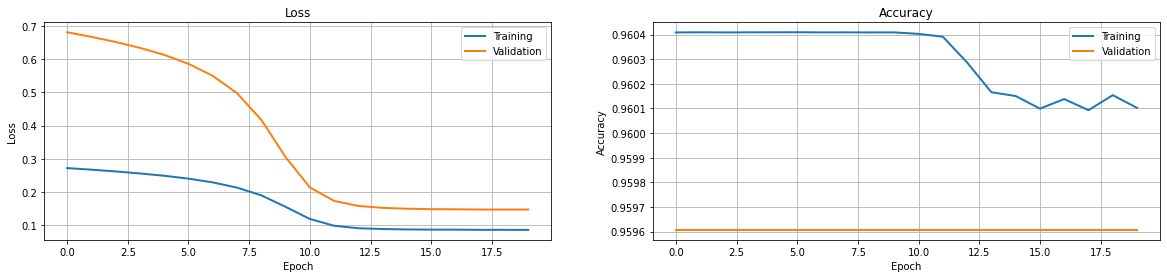

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Predict on test set
y_test_hat = tf.round(tf.sigmoid(model.predict(x_test)))

# Print a few examples of indices where label equals True
for ind in range(10):
  print("True:", np.where(y_test[ind] == 1.))
  print("Pred:", np.where(y_test_hat[ind] == 1.), "\n")

# Print a few examples of whole vectors
print("Test ground-truth:")
print(y_test[:5])
print("\n Test prediction:")
print(y_test_hat[:5])

True: (array([3]),)
Pred: (array([0]),) 

True: (array([ 9, 10, 11]),)
Pred: (array([0]),) 

True: (array([22, 25, 57]),)
Pred: (array([0]),) 

True: (array([ 0, 30]),)
Pred: (array([0]),) 

True: (array([ 2,  3,  6, 14, 23, 50, 59]),)
Pred: (array([0]),) 

True: (array([0, 5]),)
Pred: (array([0]),) 

True: (array([0, 2, 4]),)
Pred: (array([0]),) 

True: (array([ 1, 29]),)
Pred: (array([0]),) 

True: (array([ 0,  1,  3,  5, 27]),)
Pred: (array([0]),) 

True: (array([0, 2]),)
Pred: (array([0]),) 

Test ground-truth:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  

In [ ]:
# Get embeddings
embeddings = np.copy(model.layers[0].get_weights()[0])

print(embeddings.shape)
print(embeddings.min())
print(embeddings.max())

(1000, 64)
-0.8470196
0.77891064


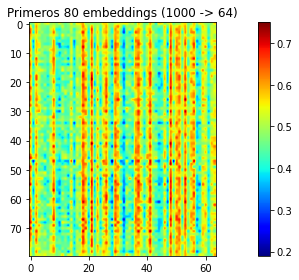

In [ ]:
#
embeddings -= embeddings.min()
embeddings /= embeddings.max()

# Plot embeddings
plt.figure(figsize=(12, 4))
plt.imshow(embeddings[:80], cmap='jet')
plt.title('Primeros 80 embeddings (1000 -> 64)')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# == Q1 ==
# A pesar de tener muy buena exactitud, la pérdida no bajó de 0.13, y más aún,
# la salida de la celda anterior muestra que se equivocó al pronosticar las clases positivas,
# incluso en el set de entrenamiento. ¿Por qué crees que eso sucede?

# == Q2 ==
# ¿Recuerdas cómo funciona el layer Embedding? ¿Qué significan los parámetros de
# entrada y salida?

# == Q3 ==
# Diseña y entrena un modelo que minimice la péridida hasta 0.05 o menos.
# Además de jugar con los parámetros que ya conocemos, como el número de layers,
# el número de parámetros en cada layer, loss, optimizer, etc., si quieres
# también explora otros valores para el número de palabras totales en el diccionario
# (definidas en el Tokenizer) y los argumentos para el padding.